# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


In [2]:
%%javascript 
//Remove the scrolling windows within this notebook
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:

**PCA**
- I think the first output dimension from PCA will highlight a large variantion in the size of spending and would likely distinguish small shops at one end from supermarkets. With this in mind I think the features of Milk and Grocery spending would inidcate this. 
- Another feature that might show up is the spending for restarants vs other clients which might be derived from spending on only Fresh and Delicatessen products.

**ICA**
- I think the ICA will highlight different types of clients such as restaurants who don't require frozen goods vs shops and supermarkets which will be based of Milk and Grocery

**It should be noted that all features are in the same unit($), which gives us variation between clients that spend a lot of money and those that spend little, and due to this I will not scale the data**

In [3]:
#Lets look at the descriptive statistics per feature
pd.set_option('precision',2)
stats = pd.DataFrame()
for feature in data:
    array = data[feature]
    row = pd.Series(name=array.name, index=['Min', 'Max', 'Mean', 'Median', 'Std'])
    row['Min'] = np.min(array)
    row['Max'] = np.max(array)
    row['Mean'] = np.mean(array)
    row['Median'] = np.median(array)
    row['Std'] = np.std(array, ddof=1)
    stats[feature] = row
print stats.T

                  Min     Max      Mean  Median       Std
Fresh               3  112151  12000.30  8504.0  12647.33
Milk               55   73498   5796.27  3627.0   7380.38
Grocery             3   92780   7951.28  4755.5   9503.16
Frozen             25   60869   3071.93  1526.0   4854.67
Detergents_Paper    3   40827   2881.49   816.5   4767.85
Delicatessen        3   47943   1524.87   965.5   2820.11


From the descriptive statistics we can see that the Fresh feature has the largest variation at 12,000 followed by Grocery and Milk. From this I believe these features will show up to be more important in our analysis than the other features

### PCA


Data shape
(440, 6)

Components
['Fresh' 'Milk' 'Grocery' 'Frozen' 'Detergents_Paper' 'Delicatessen']
[[-0.977 -0.121 -0.062 -0.152  0.007 -0.068]
 [-0.111  0.516  0.765 -0.019  0.365  0.057]
 [-0.179  0.51  -0.276  0.714 -0.204  0.283]
 [-0.042 -0.646  0.375  0.646  0.149 -0.02 ]
 [ 0.016  0.203 -0.16   0.22   0.208 -0.917]
 [-0.016  0.033  0.411 -0.013 -0.871 -0.265]]

Explained Variance Ratio
[ 0.46   0.405  0.07   0.044  0.015  0.006]


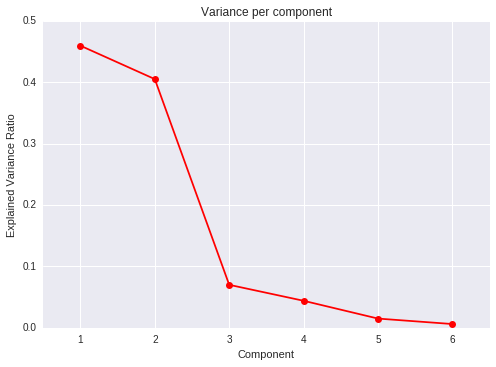

In [4]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
print "\nData shape"
print data.shape

from sklearn.decomposition import PCA
#No need to center the data as PCA will do this for us. 
pca = PCA(n_components=6)
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
np.set_printoptions(precision=3)
print "\nComponents"
print data.columns.values
print pca.components_
print "\nExplained Variance Ratio"
print pca.explained_variance_ratio_

import seaborn as sns
sns.set_style("darkgrid")
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, "-ro")
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance per component')
plt.xlim(xmin=0.5, xmax=6.5)
plt.show()

**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 

The variance is high for the first and second components at above .4, then drops quickly to the third component with it having a variance of < .1, as shown in the plot "Variance per component".

Due to this I would choose to use the first 2 components for analysis. 

I would do this as the explained variation ratio is an indication of how much variation is captured in a component, and with components 3,4,5,6 having such a small value they would have little impact on the outcome and could be considered noise.

**3)** What do the dimensions seem to represent? How can you use this information?

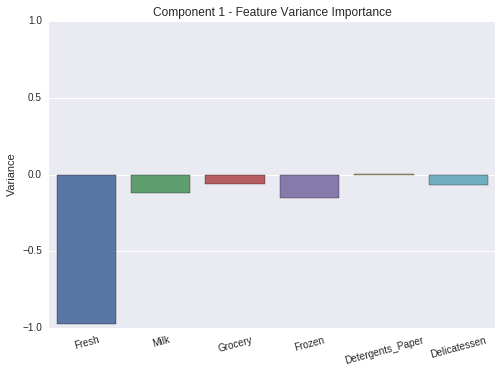

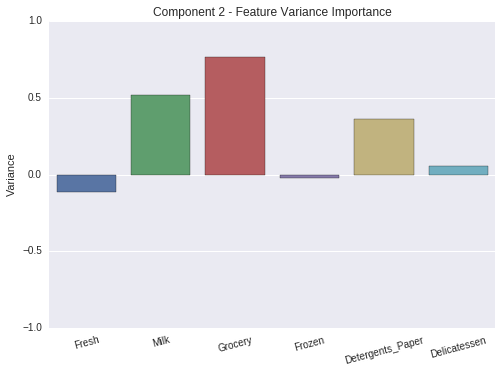

In [5]:
for i, component in enumerate(pca.components_[:2]):
    plt.ylim([-1.,1.])
    plt.ylabel('Variance')
    plt.title("Component %s - Feature Variance Importance" % (i + 1))
    plt.xticks(rotation=15)
    sns.barplot(data.columns.values, component)
    plt.show()

Answer: 
- The first component shows a large correlation with the Fresh feature. This would indicate that there is large variation of client spending on Fresh food vs spending on all features equally.
- The second component shows a large variance between clients that spend more on Grocery, Milk and Detergents than on the features Fresh, Frozem and Delicatessen.

We can use this information to think about possible client types. For example, the large variation in Fresh spending could indicate some clients spend very little on fresh foods, while other clients spend the normal amount.

### ICA

In [6]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!

#Subtract the mean from the data
#create new dataframe with data adjusted to have the mean centered around 0
ica_data = data.copy()
ica_data -= ica_data.mean(axis=0)
ica_data /= ica_data.std(axis=0)
    
from sklearn.decomposition import FastICA
ica = FastICA(n_components=4, random_state=1)
ica.fit(ica_data)

# Print the independent components
print ica.components_

[[-0.006  0.011 -0.004 -0.004 -0.01   0.046]
 [ 0.05   0.     0.001 -0.004 -0.001 -0.006]
 [ 0.011  0.002 -0.002 -0.054 -0.003  0.015]
 [-0.003 -0.013 -0.019 -0.002 -0.02   0.008]]


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: The vectors can be used to identify client groups. Below I try to pick a likely client group based on the vector.

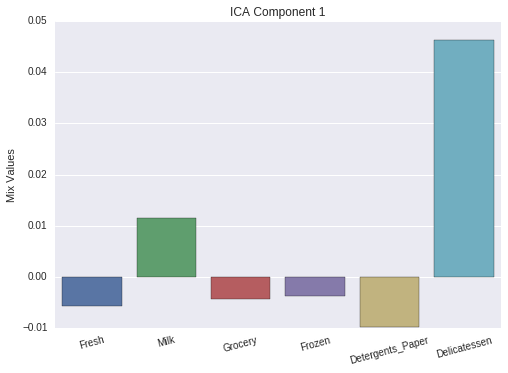

In [7]:
def bar_char_ica(i):
    plt.ylabel('Mix Values')
    plt.title("ICA Component %s" % i)
    plt.xticks(rotation=15)
    sns.barplot(data.columns.values, ica.components_[i-1])
    plt.show()
    
bar_char_ica(1)

ICA Component 1 shows a strong independance for clients that spend on delicatessen compared to an even spending on other features. These clients could be delicatessens.

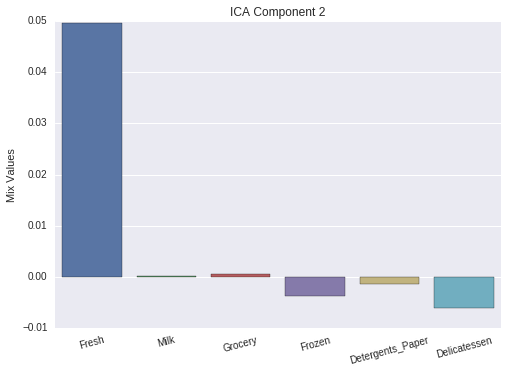

In [8]:
bar_char_ica(2)

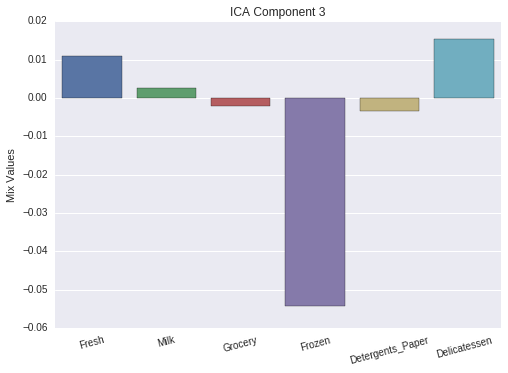

In [9]:
bar_char_ica(3)

ICA Component 3 shows strong independance on clients that spend on Fresh, Delicatessen vs Frozen. These could be restaurants.

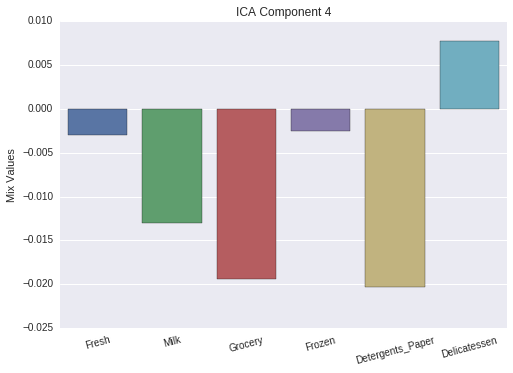

In [10]:
bar_char_ica(4)

ICA Component 4 shows an independant vector that indicates spending on Delicatessen vs spending on Milk, Grocery, Detergents. These clients could be restaurants.

**Note** It should be mentioned that the positive/negative direction of the vectors does not indicate positive or negative spending. They inidcate negative correlations.

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 

**K Means** 

- Fast

- Simple to calculate

- At each iteration a point is classified with exactly one cluster

- Creates straight line boundaries

- A cluster cannot cross another cluster

- Will bias towards clusters of the same size

**GMM** 

- Uses eliptical boundaries on any axis

- Will not bias towards clusters of even sample sizes

- At each iteration a point has a value indicating how strongly it is within a cluster

- A cluster can cross another cluster

I have chosen to use GMM as I believe we will get tighter clustering groups that are not biased to the number of samples in a cluster.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [11]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [12]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
pca2 = PCA(n_components=2)
reduced_data = pca2.fit_transform(data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.022   1585.519]
 [  4426.805   4042.452]
 [  4841.999   2578.762]
 [  -990.346  -6279.806]
 [-10657.999  -2159.726]
 [  2765.962   -959.871]
 [   715.551  -2013.002]
 [  4474.584   1429.497]
 [  6712.095  -2205.909]
 [  4823.634  13480.559]]


In [13]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
#cl = GMM(n_components=4)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def tidy_data(a, b, col):    
    min_data = min(a[col].min(), b[col].min())
    a[col] += abs(min_data)    
    b[col] += abs(min_data)            
    return a, b


#Lets visualise what a few different clusters would look like
#To do this
# -> swap the x-axis
# -> convert to a standard scale, mean = 0
# -> translate by 1,1
# -> plot on log graph
def plot_clusters(model, plot_data, title, xlim=None, ylim=None):
    centroids = model.means_
    group = model.predict(plot_data)
    i = model.n_components    
    
    colx = "PCA 1"
    coly = "PCA 2"
    col_colour = "color"
    
    #Lets transform the data to a good space so we can log graph them
    scaler.fit(plot_data)
    
    centroids_data = pd.DataFrame(scaler.transform(centroids), columns=[colx, coly])
    centroids_data[colx] *= -1. #The x-axis is the wrong way    
    samples_data = pd.DataFrame(scaler.transform(plot_data), columns=[colx, coly])
    samples_data[colx] *= -1. #The x-axis is the wrong way
    
    #Lets translate the graph so we can plot it
    mov = 1.
    samples_data[colx] += mov 
    samples_data[coly] += mov    
    centroids_data[colx] += mov    
    centroids_data[coly] += mov
       
    
    
    pal = sns.color_palette("deep", centroids_data.shape[0])
    #Add the group to the frames
    centroids_data[col_colour] = [pal[a] for a in centroids_data.index]
    samples_data[col_colour] = [pal[a] for a in pd.Series(group)]

        
    sns.set_style("whitegrid")
    f, ax = plt.subplots()
    ax.set(xscale="log", yscale="log")    
    a = xlim or [10.**-1.5, 10.**1.5]
    plt.xlim(xlim or [10.**-1.5, 10.**1.5])
    plt.ylim(ylim or [10.**-1.5, 10.**1.5])
    plt.title(title)
    #Plot the samples
    sns.regplot(x=colx, 
                y=coly, 
                data=samples_data, 
                ax=ax,
                scatter_kws={"s": 50, "c":samples_data[col_colour]}, 
                fit_reg=False)
    
    #Plot the clusters
    sns.regplot(x=colx, 
                y=coly, 
                data=centroids_data, 
                ax=ax,                 
                scatter_kws={"s": 300, "c":centroids_data[col_colour], "edgecolor":'black', "linewidth":'2'}, 
                fit_reg=False)

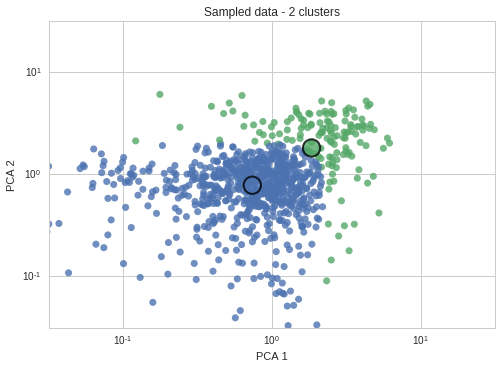

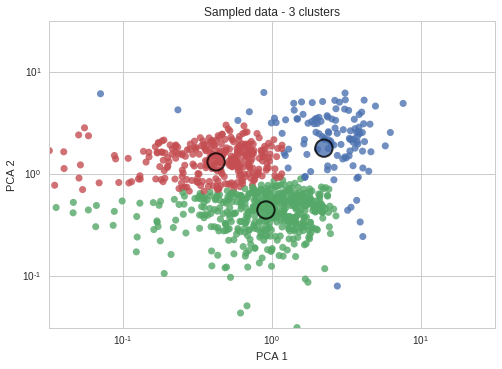

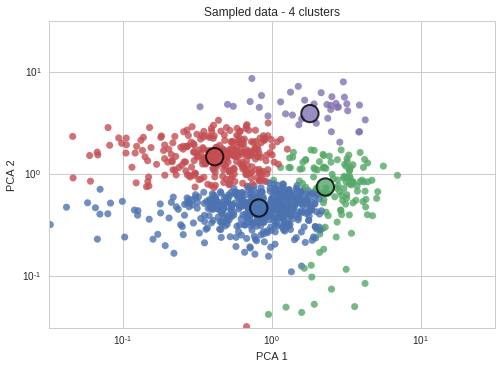

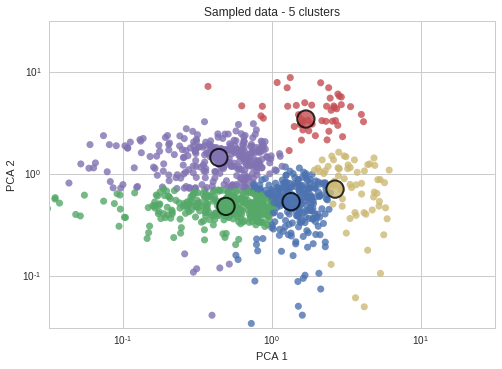

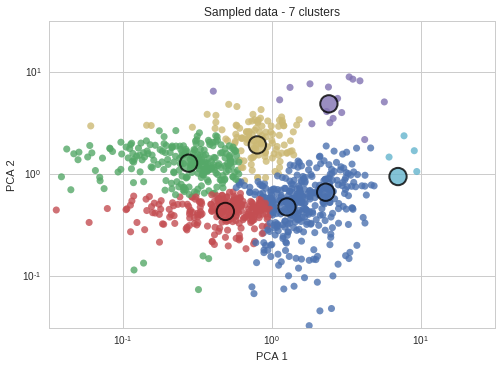

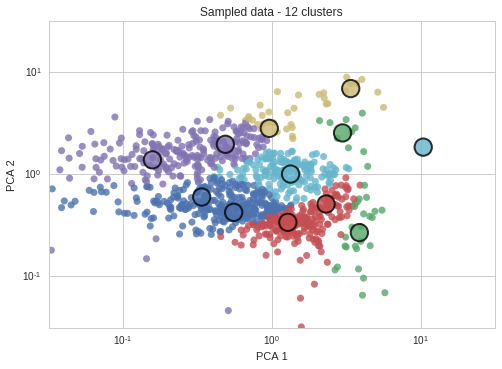

In [14]:
#Lets plot different cluster sizes
for i in [2, 3, 4, 5, 7, 12]:
    cl = GMM(n_components=i)
    cl.fit(reduced_data)                 
    samples = cl.sample(1000)    
    plot_clusters(cl, samples, "Sampled data - %s clusters" % i)
    
plt.show()

The graphs above show plots with 1000 samples from the GMM model. Each color represents the cluster that the model predicted from the sample. The large circles with the black outline show the cluster means.

From these we can see that we have good cluster grouping when using 3 clusters. We can investigate further by graphing the bic scores.

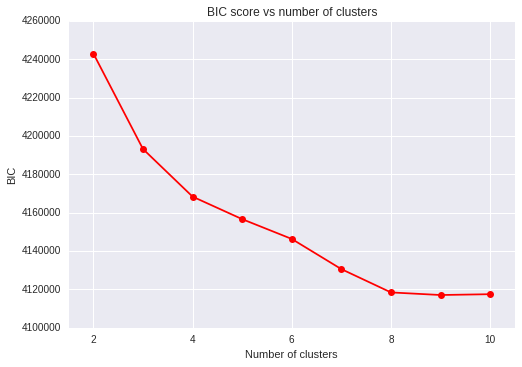

In [15]:
bic_scores = pd.DataFrame(columns=['bic', 'clusters'])
for i in range(2, 11):
    cl = GMM(n_components=i)
    cl.fit(reduced_data)
    clusters = cl
    samples = cl.sample(100000)
    group = cl.predict(samples)    
    
    #Lets get the bic scores to graph
    bic_scores.loc[len(bic_scores)] = [cl.bic(samples), i]
    
#Draw the bic score graph
sns.set_style("darkgrid")
plt.plot(bic_scores['clusters'], bic_scores['bic'], '-ro')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.title('BIC score vs number of clusters')
plt.xlim(xmin=1.5, xmax=bic_scores.shape[0] +1.5)
plt.show()

From this plot we can see that BIC score is high with 2 clusters, and declines steeply between cluster 2 and 3. From the 3rd cluster onwards the rate of decline is reduced.

From the above I would say that 3 clusters would be sufficient for our clustering purposes.

Centroids:
[[  6987.951   4249.829]
 [   269.053  -6506.887]
 [-17879.186  10122.792]]


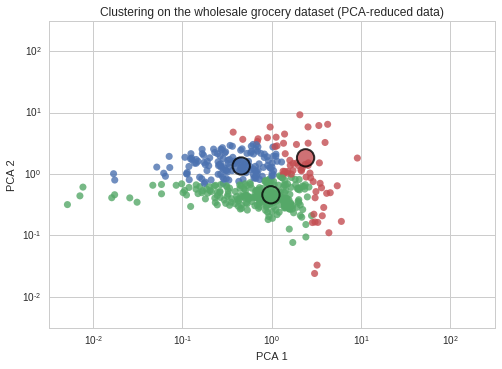

In [16]:
#Lets plot our reduced data
i = 3
cl = GMM(n_components=i)
cl.fit(reduced_data)
xlim=[10.**-2.5, 10.**2.5]
print "Centroids:"
print cl.means_
plot_clusters(cl, reduced_data, 'Clustering on the wholesale grocery dataset (PCA-reduced data)', xlim, xlim)
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 
From the PCA analysis work in the PCA section above above, we have descriptions for the x and y axis.

**x-axis - PCA 1**

The x axis inidcates the ratio of client spending on Fresh vs spending on the other features. Far left indicates less spending on Fresh than other features and the right indicates an equal spending on Fresh and other features.

**y-axis - PCA 2**

The y axis inidcates higher spending on Milk, Grocery and Detergents and less spending on Fresh, Frozen and Delicatessen. 

**Client Groups**
- The green group can be described as clients that spend on evenly on all items except Fresh. These could be shops  without fresh produce, like corner stores.

- The blue group can be described as clients that spend more on Milk, Grocery and Detergents but do not spend on Fresh. These could be supermarkets.

- The red group can  be described as clients that spend on fresh with varying spending amounts on Milk, Grocery and Detergents. These could be cafes or resturants.

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: I feel that PCA and clustering gave me good insights into the data. 

From PCA I could see that most of the information in the dataset could be gained from only 2 dimensions of the transformerd data. From this we could see that the other PCA components add only a small amount of information, which we could classify as noise. So PCA can be good at removing noisy and unimportant features.

The clustering was shown to be a good way to group the data, and in this case it was nice to be able to visualize it in 2 dimensions. Although I will mention that visualising the clusters did not give me an clear indication of the number of clusters to use. The BIC score was informative in this regard as was shown in the plot.

**9)** How would you use that technique to help the company design new experiments?

Answer: We could design an A/B test around delivery times, where we could use the above information to target client types.

For example we could use customers identified in our Red group to see if they prefer delivery in the morning or evening.

- Our control group will have delivery in the evening

- Our test group will have delivery in the morning.

- Our success metric will be the happiness of the client for this delivery time.


**10)** How would you use that data to help you predict future customer needs?

Answer: From the A/B test we could create a supervised classifier to decide whether a customer would prefer delivery in the morning or the evening.

- Features would be spending on different types of food as like in our dataset, and the client type. 
- The label would be whether they prefer delivery in the morning or the evening. 

From this we could potentially have happier customers.